In [1]:
from pyHalo.PresetModels.cdm import CDMCorrelatedStructure, CDM
import numpy as np
import matplotlib.pyplot as plt

The two-halo term is implemented as an additional population of halos at the main deflector redshift included without tidal truncation since they are outside the virial radius. The number of these objects is determined by a boost factor

\begin{equation}
f = \frac{2}{r_{\rm{rmax}} - r_{\rm{min}}} \int_{r_\rm{min}}^{r_{\rm{max}}} \left[\xi_{\rm{2halo}}\left(x,M_{\rm{host}}\right) + \xi_{\rm{Lazar}}\left(x,M_{\rm{host}}\right) \right] dx
\end{equation}

This is the average value of the two-point function $\xi_{\rm{2halo}}\left(r, M_{\rm{host}}\right)$ computed with $\tt{ colossus}$, plus an empirical correction by Lazar et al. https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.6064L/abstract, and a factor of 2 for front/back symmetry. As seen from their Figure 4, the current implementation in {\tt{pyHalo}} matches the output from N-body simulations quite well. 

Given $f$, we make an additional draw of halos from the mass function $f \times \frac{d^2 N_{\rm{ST}}}{dm dV}$, where the second term is the Sheth-Tormen mass function. Since we are interested in clustering around the main deflector, the comoving distances $r_{\rm{min}}$ and $r_{\rm{max}}$ are taken as $r_{\rm{min}}\sim r_{\rm{vir}} \sim 0.5$ Mpc and $r_{\rm{max}} = r\left(z_{\rm{lens}}+\Delta z\right) - r\left(z_{\rm{lens}}\right)$. The second distance $r_{\rm{max}}$ is the comoving distance between a lens plane at $z = z_{\rm{lens}}$ and at $z = z_{\rm{lens}}+\Delta z$. With $z_{\rm{lens}}=0.5$ and $\Delta z = 0.02$ we find $r_{\rm{max}} = 67$ Mpc. The typical correlation length a power law in $r_{\rm{max}}$, and drops off quickly past 10 Mpc. 

This boost factor is applied to the amplitude of the line-of-sight halo mass function evaluated at $z = z_{\rm{lens}}$. The number of halos added through this contribution scales as $f \times V$, where $V\left(z, z+\Delta z\right)$ is the comoving volume of a disk at redshift $z$ with thickness $\Delta z$. Since $V \propto \left(r_{\rm{rmax}} - r_{\rm{min}}\right)$, the factor $f \times V$ is a constant and the number of halos added through the two-halo contribution is independent of the choice of $\Delta z$, as it should be. 



In [18]:
zlens = 0.5
zsource = 2.0
cdm_2halo = CDMCorrelatedStructure(zlens, zsource, scale_2halo_boost_factor=1.0)
print('number of clustered halos: ', len(cdm_2halo.halos))
cdm_2halo_scaled = CDMCorrelatedStructure(zlens, zsource, scale_2halo_boost_factor=10.0)
print('number of clustered halos (scaled x 10): ', len(cdm_2halo_scaled.halos))
cdm_subhalos = CDM(zlens, zsource, LOS_normalization=0.0, sigma_sub=0.1)
print('number of subhalos: ', len(cdm_subhalos.halos))

bound_masses = np.array([halo.bound_mass for halo in cdm_subhalos.halos])
print('number of subhalos with bound masses above 10^8: ', np.sum(bound_masses>10**8))
masses = np.array([halo.mass for halo in cdm_2halo.halos])
print('number of clustered halos with virial masses above 10^8: ', np.sum(masses>10**8))

number of clustered halos:  119
number of clustered halos (scaled x 10):  916
number of subhalos:  11446
number of subhalos with bound masses above 10^8:  13
number of clustered halos with virial masses above 10^8:  0


In [13]:
lens_model_list, lens_redshift_array, kwargs_halos, _ = cdm_2halo.lensing_quantities()
# you can ignore the last argument for almost all use cases
from lenstronomy.LensModel.lens_model import LensModel
# You should use the same astropy class created in pyhalo to do lensing computations. The current default cosmology is Planck 2019
astropy_instance = cdm_2halo.astropy_instance
lens_model_halos = LensModel(lens_model_list, 
                                  zlens, 
                                  zsource, 
                                  lens_redshift_array, 
                                  cosmo=astropy_instance, 
                                  multi_plane=True)

lens_model_list, lens_redshift_array, kwargs_halos_scaled, _ = cdm_2halo_scaled.lensing_quantities()
# you can ignore the last argument for almost all use cases
from lenstronomy.LensModel.lens_model import LensModel
# You should use the same astropy class created in pyhalo to do lensing computations. The current default cosmology is Planck 2019
astropy_instance = cdm_2halo.astropy_instance
lens_model_halos_scaled = LensModel(lens_model_list, 
                                  zlens, 
                                  zsource, 
                                  lens_redshift_array, 
                                  cosmo=astropy_instance, 
                                  multi_plane=True)

lens_model_list, lens_redshift_array, kwargs_halos_subhalos, _ = cdm_subhalos.lensing_quantities()
# you can ignore the last argument for almost all use cases
from lenstronomy.LensModel.lens_model import LensModel
# You should use the same astropy class created in pyhalo to do lensing computations. The current default cosmology is Planck 2019
astropy_instance = cdm_subhalos.astropy_instance
lens_model_halos_subhalos = LensModel(lens_model_list, 
                                  zlens, 
                                  zsource, 
                                  lens_redshift_array, 
                                  cosmo=astropy_instance, 
                                  multi_plane=True)

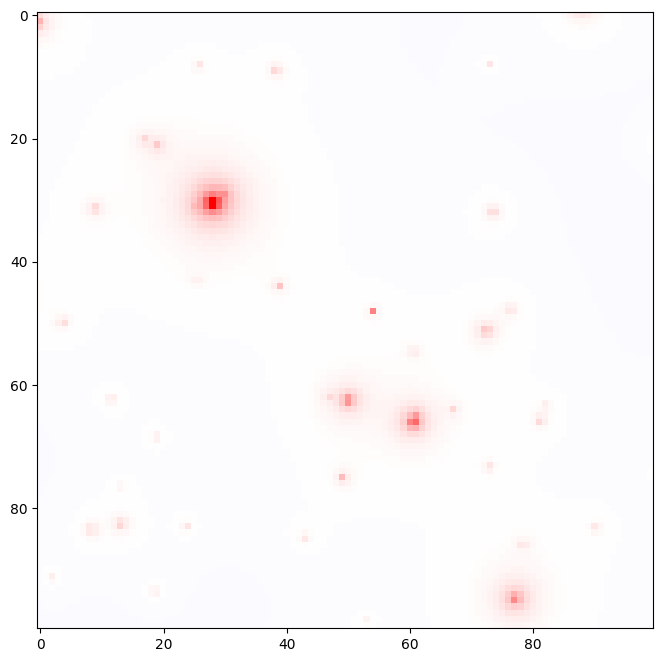

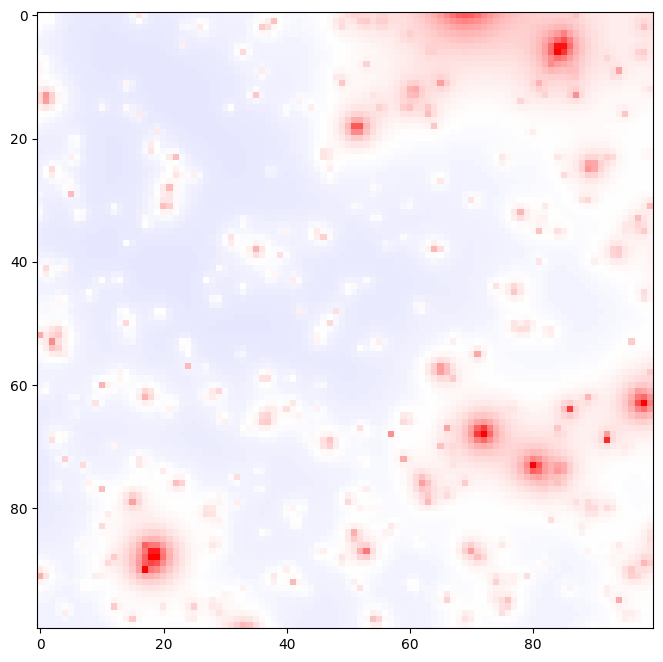

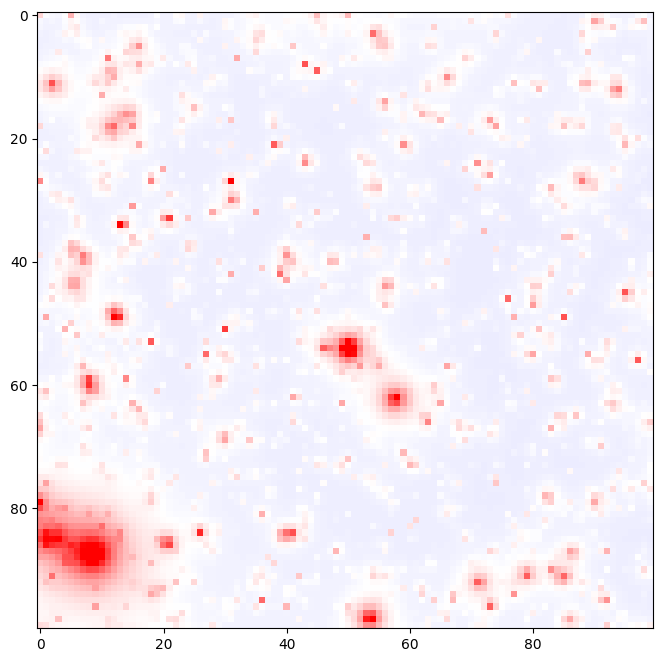

In [15]:
npix = 100 
_x = _y = np.linspace(-1.5, 1.5, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape
kappa = lens_model_halos.kappa(xx.ravel(), yy.ravel(), kwargs_halos).reshape(shape0)
kappa_scaled = lens_model_halos_scaled.kappa(xx.ravel(), yy.ravel(), kwargs_halos_scaled).reshape(shape0)
kappa_subs = lens_model_halos_subhalos.kappa(xx.ravel(), yy.ravel(), kwargs_halos_subhalos).reshape(shape0)

fig = plt.figure(1)
fig.set_size_inches(8,8)
plt.imshow(kappa-np.mean(kappa), vmin=-0.03, vmax=0.03, cmap='bwr')

fig = plt.figure(2)
fig.set_size_inches(8,8)
plt.imshow(kappa_scaled-np.mean(kappa_scaled), vmin=-0.03, vmax=0.03, cmap='bwr')

fig = plt.figure(3)
fig.set_size_inches(8,8)
plt.imshow(kappa_subs-np.mean(kappa_subs), vmin=-0.03, vmax=0.03, cmap='bwr')

### Here will compare the number of subhalos with bound masses above 10^8 with field halos having virial masses above 10^8 without shot-noise 

In [17]:
zlens = 0.5
zsource = 2.0
cdm_2halo_scaled = CDMCorrelatedStructure(zlens, zsource, scale_2halo_boost_factor=1.0 * 50)
cdm_subhalos = CDM(zlens, zsource, LOS_normalization=0.0, sigma_sub=0.1 * 50)

bound_masses = np.array([halo.bound_mass for halo in cdm_subhalos.halos])
print('median # of subhalos with bound masses above 10^8: ', np.sum(bound_masses>10**8)/50)
masses = np.array([halo.mass for halo in cdm_2halo_scaled.halos])
print('median # of correlated structure halos with virial masses above 10^8: ', np.sum(masses>10**8)/50)

median # of subhalos with bound masses above 10^8:  9.08
median # of correlated structure halos with virial masses above 10^8:  1.46
